In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
transform = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0), antialias=None),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=224),  # Image net standards
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # Imagenet standards
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(size=256, antialias=None),
            transforms.CenterCrop(size=224),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(size=256, antialias=None),
            transforms.CenterCrop(size=224),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [4]:
class Dataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""

    def __init__(self, dir, transform=None):
        """Method to initilaize variables."""
        self.transform = transform
        labels, paths, data = list(), list(), list()

        for label, folder in enumerate(os.listdir(".\cats_and_dogs\\test")):
            new_data = os.listdir(dir + "\\" + folder)
            paths.extend(folder + "\\" + path for path in new_data)
            labels.extend([label] * len(new_data))

        for path in paths:
            img = (
                np.asarray(Image.open(dir + "\\" + path).resize((150, 150)))
                .reshape(150, 150, 3)
                .astype("float32")
            )
            data.append(img / 255)

        self.data = np.array(data)
        self.labels = np.array(labels)
        print(self.data.shape)

    def __getitem__(self, index):
        label = self.labels[index]
        data = self.data[index]

        if self.transform is not None:
            data = self.transform(data)
            data = data

        return data, label

    def __len__(self):
        return len(self.data)

In [5]:
# Transform data into Tensor that has a range from 0 to 1
train_set = Dataset(".\cats_and_dogs\\train", transform=transform["train"])
test_set = Dataset(".\cats_and_dogs\\test", transform=transform["test"])
val_set = Dataset(".\cats_and_dogs\\validation", transform=transform["val"])

(2000, 150, 150, 3)
(50, 150, 150, 3)
(1000, 150, 150, 3)


In [6]:
def output_label(label):
    output_mapping = {
        0: "Cat",
        1: "Dog",
    }
    input = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input]


In [7]:
train_loader = DataLoader(train_set, batch_size=5, shuffle= True)
test_loader = DataLoader(test_set, batch_size=5)
val_loader = DataLoader(val_set, batch_size=5)

In [8]:
a = next(iter(train_loader))
a[0].shape

torch.Size([5, 3, 224, 224])

In [9]:
len(train_set)

2000

0


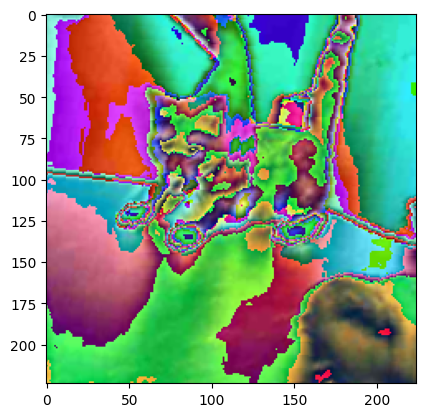

In [10]:
t = transforms.ToPILImage()

image, label = next(iter(train_set))
plt.imshow(t(image), cmap="gray")
print(label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 224, 224]) torch.Size([10])
labels:  Dog, Cat, Dog, Dog, Dog, Dog, Dog, Dog, Cat, Dog, 

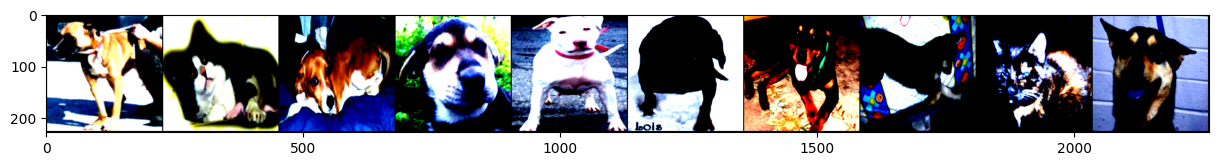

In [11]:
demo_loader = DataLoader(test_set, batch_size=10, shuffle=True)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [19]:
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Linear(in_features=50176, out_features=1024)
        self.bn3 = nn.BatchNorm1d(1024)
        nn.init.kaiming_normal_(self.layer3.weight, mode='fan_out', nonlinearity='relu')

        self.layer4 = nn.Linear(in_features=1024, out_features=2048)
        self.bn4 = nn.BatchNorm1d(2048)
        nn.init.kaiming_normal_(self.layer4.weight, mode='fan_out', nonlinearity='sigmoid')

        self.layer5 = nn.Linear(in_features=2048, out_features=512)
        self.bn5 = nn.BatchNorm1d(512)
        nn.init.kaiming_normal_(self.layer5.weight, mode='fan_out', nonlinearity='relu')

        self.layer6 = nn.Linear(in_features=512, out_features=512)
        self.bn6 = nn.BatchNorm1d(512)
        nn.init.kaiming_normal_(self.layer6.weight, mode='fan_out', nonlinearity='sigmoid')

        self.layer7 = nn.Linear(in_features=512, out_features=128)
        self.bn7 = nn.BatchNorm1d(128)
        nn.init.kaiming_normal_(self.layer7.weight, mode='fan_out', nonlinearity='relu')

        self.output_layer = nn.Linear(in_features=128, out_features=2)
        nn.init.kaiming_normal_(self.output_layer.weight, mode='fan_out', nonlinearity='sigmoid')

    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        out = self.layer2(out)

        out = out.view(out.size(0), -1)


        out = self.layer3(out)
        out = self.bn3(out)
        out = nn.ReLU()(out)

        out = self.layer4(out)
        out = self.bn4(out)
        out = nn.Sigmoid()(out)

        out = self.layer5(out)
        out = self.bn5(out)
        out = nn.ReLU()(out)

        out = self.layer6(out)
        out = self.bn6(out)
        out = nn.Sigmoid()(out)

        out = self.layer7(out)
        out = self.bn7(out)
        out = nn.ReLU()(out)

        out = self.output_layer(out)
        out = nn.Sigmoid()(out)
        return out

In [20]:
model = ClassificationCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

ClassificationCNN(
  (layer0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Linear(in_features=50176, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-0

In [21]:
num_epochs = 100
count = 0
# Lists for visualization of loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []
loss_ = 0


pbar = tqdm(range(num_epochs))
for epoch in pbar:
    model.train()
    curr_loss = 0
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = error(outputs, labels)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        # Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

        curr_loss+= loss.item()
    count += 1
    loss_ = curr_loss/len(train_loader)
    pbar.set_postfix({'loss': loss_})
    loss_list.append(loss_)

    # Testing the model
    model.eval()
    total = 0
    correct = 0
    predictions_list = list()
    labels_list = list()
    
    for images, labels in val_loader:
        images, labels = images.squeeze().to(device), labels.to(device)
        labels_list.extend(labels.cpu().detach().tolist())
        
        outputs = model(images.to(torch.float32))

        predictions = torch.argmax(outputs, 1).cpu().detach().tolist()
        predictions_list.extend(predictions)
    labels_list, predictions_list = np.asarray(labels_list), np.asarray(predictions_list)
    
    correct = (predictions_list == labels_list).sum()
    total = len(labels_list)

    accuracy = correct * 100 / total
    iteration_list.append(count)
    accuracy_list.append(accuracy)

  5%|▌         | 5/100 [06:30<2:03:35, 78.06s/it, loss=0.695]


KeyboardInterrupt: 

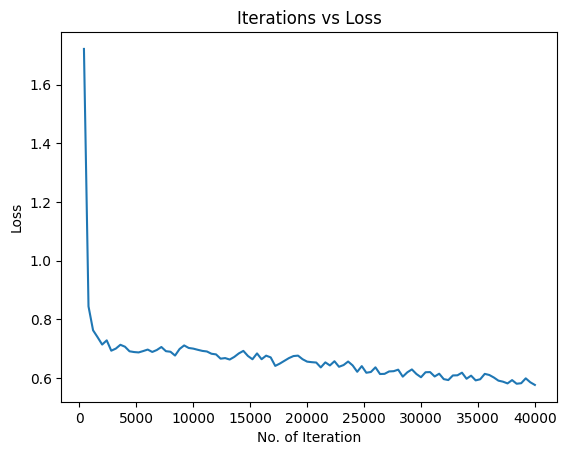

In [117]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [118]:
max(accuracy_list), min(loss_list)

(70.4, 0.5763420334085823)

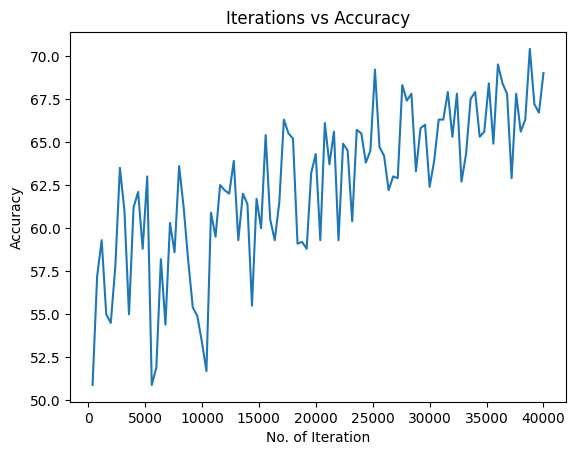

In [119]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [120]:
test_labels_list, test_predictions_list = list(), list()
for images, labels in test_loader:
    images, labels = images.squeeze().to(device), labels.to(device)
    test_labels_list.extend(labels.cpu().detach().tolist())
    
    outputs = model(images.to(torch.float32))

    test_predictions = torch.argmax(outputs, 1).cpu().detach().tolist()
    test_predictions_list.extend(test_predictions)
test_labels_list, test_predictions_list = np.asarray(test_labels_list), np.asarray(test_predictions_list)
correct = (test_predictions_list == test_labels_list).sum()
total = len(test_labels_list)

accuracy = correct * 100 / total
accuracy

70.0